In [22]:
import numpy as np
import torch

In [23]:
from utility import predict_fuc, load_best_model
from smalltransformer import SmallTransformer

In [24]:
batch_size = 1
model = SmallTransformer().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# model, optimizer, best_val_loss, target_min, target_max = load_best_model(
#     model, optimizer,
#     '/kaggle/input/noisereduction/pytorch/default/1/best_model_NR_v2.0.pth')
model, optimizer, best_val_loss, target_min, target_max = load_best_model(
    model, optimizer, '/kaggle/best_model_ST_v1.0.pth')

Best model loaded.


In [25]:
from linear_process import preprocess_pro
from utility import cal_flux, predict_spectra

In [26]:
# predictions_spectra_test = preprocess_pro('test')

In [27]:
import pickle
with open('train_preprocessed.pkl', 'rb') as file:
    full_predictions_spectra_test = pickle.load(file)

In [28]:
full_predictions_spectra_test.shape

(673, 187, 283)

In [29]:
from sklearn.metrics import r2_score, mean_squared_error

auxiliary_folder = 'input/ariel-data-challenge-2024/'
train_solution = np.loadtxt(
    '/kaggle/input/ariel-data-challenge-2024/train_labels.csv',
    delimiter=',',
    skiprows=1)

targets = train_solution[:, 1:]

In [30]:
from sklearn.cluster import KMeans

flattened_labels = targets.reshape(673, -1)

# 使用 K-means 聚类
n_clusters = 10  # 你可以根据需要调整聚类数量
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(flattened_labels)
cluster_labels = kmeans.labels_

c:\veighna_studio\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [31]:
np.random.seed(21)
# 从每个聚类中随机抽取样本
sampled_indices = []
samples_per_cluster = 320 // n_clusters  # 每个聚类中抽取的样本数量
for cluster in np.unique(cluster_labels):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    if len(cluster_indices) >= samples_per_cluster:
        sampled_indices.extend(
            np.random.choice(cluster_indices,
                             samples_per_cluster,
                             replace=False))
    else:
        sampled_indices.extend(cluster_indices)  # 如果样本数量不足，全部选取

# 如果总样本数量不足 320，补充剩余的样本
if len(sampled_indices) < 320:
    remaining_indices = np.setdiff1d(
        np.arange(full_predictions_spectra_test.shape[0]), sampled_indices)
    additional_samples = np.random.choice(remaining_indices,
                                          320 - len(sampled_indices),
                                          replace=False)
    sampled_indices.extend(additional_samples)

In [32]:
mask = np.ones(full_predictions_spectra_test.shape[0], dtype=bool)
mask[sampled_indices] = False
predictions_spectra_test = full_predictions_spectra_test[mask]

In [33]:
predictions_spectra_test.shape

(353, 187, 283)

In [34]:
whitelight_s_test = np.array([
    predict_spectra(predictions_spectra_test[i])
    for i in range(len(predictions_spectra_test))
])  # 预测每个星球的白光缩放比例S

data_test_reshaped = torch.tensor(predictions_spectra_test).float()

In [35]:
all_predictions = predict_fuc(model, data_test_reshaped, batch_size=1)
all_predictions = all_predictions * (target_max - target_min) + target_min
all_predictions = all_predictions.numpy()
all_predictions = all_predictions * whitelight_s_test[:, np.newaxis]

In [36]:
all_predictions.shape

(353, 283)

In [37]:
from utility import postprocessing, competition_score
import pandas as pd

wavelengths = pd.read_csv(
    '/kaggle/input/ariel-data-challenge-2024/wavelengths.csv')
test_adc_info = pd.read_csv(
    '/kaggle/input/ariel-data-challenge-2024/test_adc_info.csv',
    index_col='planet_id')
train_labels = pd.read_csv(
    '/kaggle/input/ariel-data-challenge-2024/train_labels.csv',
    index_col='planet_id')

In [38]:
test_adc_info[mask].index

Int64Index([    785834,   24135240,   25070640,   50637799,   57518461,
              57669658,   62282335,   75219649,   79009616,   92029723,
            ...
            4167675411, 4176562407, 4185365244, 4197469272, 4199801857,
            4228013544, 4246618328, 4249337798, 4257395405, 4286133832],
           dtype='int64', name='planet_id', length=353)

In [39]:
all_predictions.shape

(353, 283)

In [40]:
targets.shape

(673, 283)

In [41]:
print(f"# R2 score: {r2_score(targets[mask], all_predictions):.3f}")
sigma_pred = mean_squared_error(targets[mask], all_predictions, squared=False)
print(f"# Root mean squared error: {sigma_pred:.6f}")

# R2 score: 0.996
# Root mean squared error: 0.000075


In [48]:
sub_df = postprocessing(all_predictions,
                        wavelengths,
                        test_adc_info[mask].index,
                        sigma_pred=np.tile(
                            np.where(test_adc_info[mask][['star']] <= 1,
                                     0.000075, 0.001), (1, 283)))

In [49]:
gll_score = competition_score(train_labels[mask].copy().reset_index(),
                              sub_df.copy().reset_index(),
                              naive_mean=train_labels[mask].values.mean(),
                              naive_sigma=train_labels[mask].values.std(),
                              sigma_true=0.00001)
print(f"# Estimated competition score: {gll_score:.3f}")

# Estimated competition score: 0.518


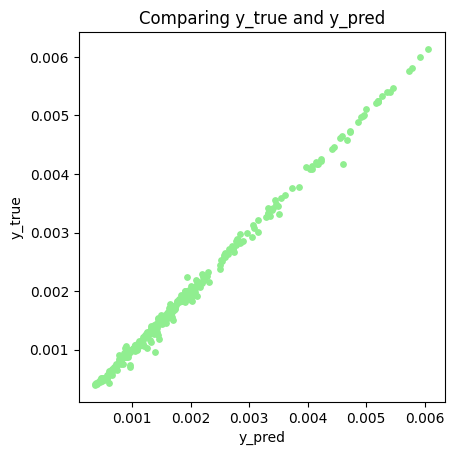

In [44]:
import matplotlib.pyplot as plt

col = 1
plt.scatter(all_predictions[:, col], targets[mask, col], s=15, c='lightgreen')
plt.gca().set_aspect('equal')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('Comparing y_true and y_pred')
plt.show()

In [45]:
import numpy as np
from scipy import stats

col = 3
# 假设 predict_targets 和 targets 是 numpy 数组
errors = np.abs(all_predictions[:, col] - targets[mask, col])
z_scores = np.abs(stats.zscore(errors))

# 设置 Z-score 阈值，通常为 3
threshold = 3
outliers = np.where(z_scores > threshold)

# 打印异常值索引
print("Outlier lens:", len(outliers[0]))
print("Outliers:", outliers)

Outlier lens: 6
Outliers: (array([217, 275, 278, 281, 286, 333], dtype=int64),)


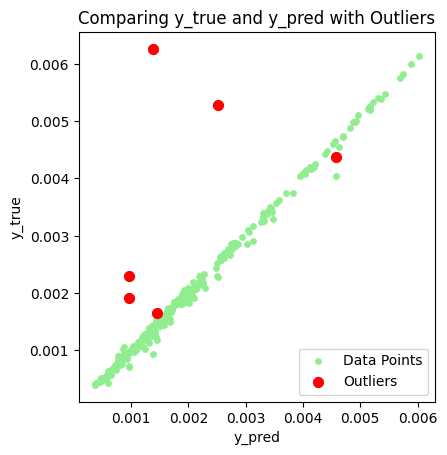

In [46]:
import matplotlib.pyplot as plt

plt.scatter(all_predictions[:, col],
            targets[mask, col],
            s=15,
            c='lightgreen',
            label='Data Points')
plt.scatter(all_predictions[outliers[0], col],
            targets[outliers[0], col],
            s=50,
            c='red',
            label='Outliers')
plt.gca().set_aspect('equal')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('Comparing y_true and y_pred with Outliers')
plt.legend()
plt.show()

In [47]:
import numpy as np
from scipy import stats
from collections import Counter, defaultdict

# 假设 predict_targets 和 targets 是 numpy 数组
num_cols = all_predictions.shape[1]
threshold = 3
outlier_counts = Counter()
normal_columns = defaultdict(list)

for col in range(num_cols):
    errors = np.abs(all_predictions[:, col] - targets[mask, col])
    z_scores = np.abs(stats.zscore(errors))
    outliers = np.where(z_scores > threshold)[0]
    normals = np.where(z_scores <= threshold)[0]

    # 统计每个异常点的频次
    outlier_counts.update(outliers)

    # 记录每个数据点在哪些列中是正常的
    for normal in normals:
        normal_columns[normal].append(col)

# 按频次排序
sorted_outliers = outlier_counts.most_common()

# 打印每个异常点的频次及其正常的列
for outlier, count in sorted_outliers:
    normal_cols = normal_columns[outlier]
    print(
        f"Data point {outlier} is an outlier in {count} columns and normal in columns: {normal_cols}"
    )

Data point 286 is an outlier in 212 columns and normal in columns: [22, 23, 24, 25, 26, 27, 28, 29, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 251, 253, 254, 255, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282]
Data point 216 is an outlier in 182 columns and normal in columns: [0, 1, 2, 3, 4, 5, 6, 7, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 271, 274, 275, 281, 282]
Data point 281 is an outlier in 181 columns and normal in columns: [21, 22, 23, 24, 25, 26, 27, 28,